In [10]:
import time
import random
import pandas as pd

from pytrends.request import TrendReq
from matplotlib import pyplot as plt
from tqdm import tqdm

# Vizu settings
%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 6)

# Local imports
from utils import load_countries, get_sampled_countries
from testchecks import check_if_valid_country_query
from typerhints import Countries, SearchTerm, HistoryFrame, HistoryFrameBlocks


In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# reproducibility
random.seed(1337)

In [12]:
DIR_AVAILABLE_COUNTRIES = "countries.txt"
DIR_UNAVAILABLE_COUNTRIES = "ignore.txt"

COUNTRY_NAMES = load_countries(filename=DIR_AVAILABLE_COUNTRIES, ignore=DIR_UNAVAILABLE_COUNTRIES)

In [13]:
LANGUAGE = 'en-US'
TIME_ZONE = 360

pytrends = TrendReq(hl=LANGUAGE, tz=TIME_ZONE)

In [14]:
def plot_history(history: list, search_terms: SearchTerm) -> None:
    for search_term in search_terms:
        plt.figure()
        for hist in history:
            plt.plot(hist[1][search_term], label=hist[0])
        plt.legend(loc='upper right')
        plt.xlabel("Date")
        plt.ylabel("Interest")
        plt.title(f"{search_term.capitalize()}: Interest Over Time")
    plt.show()

In [15]:
def get_interest_over_time(search_terms: SearchTerm, tf: str, geocode: str, fetch_interval: float = 0.25) -> HistoryFrame:
    # don't fetch too often I guess?
    time.sleep(fetch_interval)
    # create the payload for related queries
    pytrends.build_payload(search_terms, timeframe=tf, geo=geocode)
    # request data from dataframe
    payload = pytrends.interest_over_time()
    if payload.empty:
        raise ValueError(f"Dropping request: {search_terms} for geocode ({geocode})")
    return payload.drop(columns=['isPartial'])

def get_yearly_interest_by_country(search_terms: SearchTerm, year: int, geocode: str, fetch_interval: int = 1) -> HistoryFrame:
    tmp_history = []
    
    # Build timeline
    first_six_months = f"{year}-1-1 {year}-6-30"
    last_six_months = f"{year}-7-1 {year}-12-31"
    time_periods = [first_six_months, last_six_months]
    
    for time_period in time_periods:
        history_frame = get_interest_over_time(search_terms, time_period, geocode, fetch_interval)
        tmp_history.append(history_frame)
    
    # Combine the two time period from the timeline
    combined_history = pd.concat(tmp_history)
    assert combined_history.shape[0] == 365, "Expected 365 days in a year!"
    return combined_history

def get_daily_trends_by_year(search_terms: SearchTerm, year: int, countries: Countries, fetch_interval: int = 1) -> HistoryFrameBlocks:
    # check if illegal query
    if not check_if_valid_country_query(countries=countries, country_names=COUNTRY_NAMES):
        raise ValueError("Illegal query")

    # Find countries either by specific countries or random sampling by indicies
    search_countries = get_sampled_countries(countries=countries, country_names=COUNTRY_NAMES)

    trends = []
    for geocode, country in tqdm(search_countries, desc="Fetching trends", colour="green"):
        try:
            history = get_yearly_interest_by_country(search_terms, year, geocode, fetch_interval)
            trends.append((country, history))
        except ValueError as ve: 
            print("Skipping: ", ve) 
    return trends
    


### Setup query parameters

In [16]:
YEAR = 2019
FETCH_INTERVAL = 1
SEARCH_TERMS = ["ski"]
COUNTRIES = ["Norway", "Sweden", "Denmark"]

### Fetch trends from Google

In [17]:
history = get_daily_trends_by_year(search_terms=SEARCH_TERMS, year=YEAR, countries=COUNTRIES, fetch_interval=FETCH_INTERVAL)

Fetching trends: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


#### View history

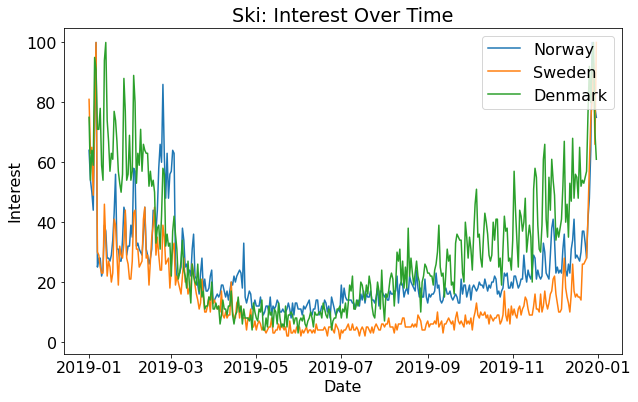

In [18]:
plot_history(history, SEARCH_TERMS)